<a href="https://colab.research.google.com/github/torkralle/colab-overtone/blob/master/Vocoder.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 下準備


## ライブラリのインポート

In [1]:
%matplotlib inline
import sys
sys.path.append('/content/drive/MyDrive/Laboratory/Colab/overtone/modules')
from scipy.io import wavfile
import numpy as np
import matplotlib.pyplot as plt
import librosa
import librosa.display
from IPython.display import display, Audio
import scipy.io.wavfile
import copy
import filter
import window_function as wf
import average_function as af
import furie_function as ff
import filter
import helper

## 音声のインポート

In [2]:
# vocal_fs: rateボーカル音
vocal_path = "/content/drive/MyDrive/Laboratory/Colab/overtone/sounds/plain.wav"
Audio(vocal_path)
vocal_fs, vocal = wavfile.read(vocal_path)

# fs: rate, vocal: data ホーミー音 高音
overtone_path = "/content/drive/MyDrive/Laboratory/Colab/overtone/sounds/overtone.wav"
Audio(overtone_path)
overtone_fs, overtone = wavfile.read(overtone_path)

## 関数の定義

### ハニング窓の定義

### 音声データの作成関数の定義

In [3]:
def create_audio(fs, s, name):
  s = s / (np.max(np.abs(s)))
  out_path = f"out-{name}.wav"
  scipy.io.wavfile.write(out_path, fs, s)
  return out_path

### 平均系の関数群の定義

In [4]:
def fft_and_shape(h):
    H = np.fft.fft(h)

    for k in range(N):
        H[k] = abs(H[k])

    for band in range(number_of_band):
        # 開始位置の定義
        offset = band_width * (band - 1) 
        for k in range(band_width):
            H[offset + k] = af.get_average(band_width , offset, H)

    H[0] = 0
    H[int(np.round(N/2))] = 0

    # 左右に代入
    for k in range(1, int(np.round(N/2))):
        H[N - k] = H[k]
    
    return H

### 畳み込み関数の定義

In [5]:
def convolution(V, B):
	# ボーカルV * ホーミーBがY
  Y = np.zeros(N)
  for k in range(N):
    Y[k] = V[k] * H[k]
  return Y

## データの下準備

### 必要な定数の定義

In [6]:
# サンプリング周波数
fs = 44100

# 2**16 65536
bits = 16
normalize_value = 2 ** (bits - 1)

# バッチ数
N = 4096

# 正規化
vocal = vocal.astype(np.float) / normalize_value
overtone = overtone.astype(np.float) / normalize_value

# vocalとovertoneの配列の長さを取得
length_of_vocal = len(vocal)
length_of_overtone = len(overtone)

# N以外の場所を取って、フレーム数を調べる
# オーバーラップアドで半分重なってるためフレーム数は
number_of_frame = int(np.round((length_of_vocal - N/2) / (N/2)))

# 8個取ってきて平均を取る 
# バンド幅が8であるから2*8で割る(フーリエ変換の折り返し分の2)
band_width = 8
number_of_band = int(np.round(N / 2 / band_width))

# 出力結果を格納する配列を作成
new_audio = np.zeros(length_of_vocal)

### データの確認

In [7]:
print(f"ボーカルのサンプリング周波数 {vocal_fs}")
print(f"ホーミーのサンプリング周波数 {overtone_fs}\n")

print(f"ボーカルの配列長 {length_of_vocal}")
print(f"ホーミーの配列長 {length_of_overtone} \n")

print(f"総フレーム数 {number_of_frame}")
print(f"総バンド数 {number_of_band}")

ボーカルのサンプリング周波数 48000
ホーミーのサンプリング周波数 48000

ボーカルの配列長 141248
ホーミーの配列長 133056 

総フレーム数 68
総バンド数 256


### データの可視化


141248
133056


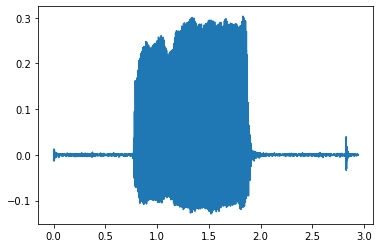

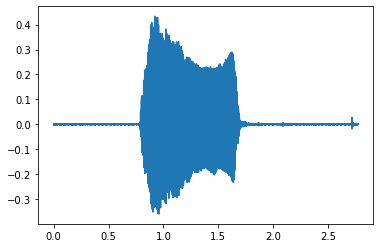

In [8]:
# 横軸（時間）の配列を作成　
# np.arange(初項, 等差数列の終点, 等差)
vocal_t = np.arange(0, vocal.shape[0]/vocal_fs, 1/vocal_fs)  
plt.figure()
plt.plot(vocal_t, vocal)
plt.savefig('vocal.png')
print(length_of_vocal)

overtone_t = np.arange(0, overtone.shape[0]/overtone_fs, 1/overtone_fs)  
plt.figure()
plt.plot(overtone_t, overtone)
plt.savefig('overtone.png')
print(length_of_overtone)

# 本処理

In [9]:
# ホーミーにハイパスフィルターを掛ける
overtone = filter.highpass_filter(overtone)

for frame in range(number_of_frame):
    # フーリエ変換のために、ハニング窓を乗算する
    # ボーカル
    v, is_limit = wf.multiply_hanning_window(vocal, frame, length_of_vocal)
    if(is_limit):
        break
    V = np.fft.fft(v)

    # ホーミー
    h, is_limit = wf.multiply_hanning_window(overtone, frame, length_of_overtone)
    if(is_limit):
      break
    H = fft_and_shape(h)    

    # ボーカルV ホーミーHとの畳込み
    Y = convolution(V, H)
    y = np.real(np.fft.ifft(Y))

		# バッチ処理なので、順にyをnew_audioに足していく
    offset =  int(np.round(N / 2 * (frame - 1)))
    for n in range(N):
        new_audio[offset+n] = new_audio[offset+n] + y[n]

new_audio = new_audio / max(new_audio) * 0.5

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: ComplexWarning: Casting complex values to real discards the imaginary part
  """


this is limit index,  133056


In [10]:
path = create_audio(fs, new_audio, "43")
Audio(path)